# Spectral Gap Superposition States via Adiabatic Thermalization

The estimation of the spectral gap, 
defined as the energy difference between the ground state 
and the first excited state of a quantum system, 
is fundamental in both condensed matter physics
and quantum chemistry.

Unfortunately most of the Quantum Computing schemes
remain out of reach since we are 
currently living 
in the so-called Noisy Intermediate-Scale Quantum (NISQ) era,
in which actual devices are made 
of a limited number of noisy qubits.
In notebook, 
we showcase how to apply a novel approach 
for estimating the spectral gap in quantum systems. 
We define the Spectral Gap Superposition(SGS) state as

$$
\ket{SGS(0,1)} = \frac{1}{\sqrt{2}}\left(\ket{\Omega_0}  + \ket{\Omega_1} \right),
$$

where $\ket{\Omega_0}$ and $\ket{\Omega_1}$
respectively are the groundstate and the first excited state
of the system Hamiltonian $H$.

The procedure can be schematized as follows: A Quantum Circuit prepares the Spectral Gap Superposition
State (SGS) through Adiabatic Thermalization. Then, sequential measurements of the chosen observable $O(t)$ at different time
steps are conducted, followed by a fitting procedure to determine the spectral gap. The obtained value is compared to the
benchmark spectral gap.

![scheme](images/scheme.png)

In [1]:
import pennylane as qml
# from pennylane 
import numpy as np
import jax.numpy as jnp
np.random.seed(1)

## 2D Ising model

To demonstrate the effectiveness of the approach we at first show that is possible to give an estimate of the spectral gap for the 2D Ising model with transverse field for a single field intensity. In the next section we will iterate the procedure to span all the regimes/phases.

The Hamiltonian under study has the following form:
$$H = -\frac{J_z}{2} \sum_{\langle i,j \rangle} Z_i Z_j - \frac{h}{2}\sum_i X_i$$

So let's define the useful variables.

In [2]:
edge_sites = 2
n_qubits = edge_sites**2

JZ = 1 # only Z coupling
JX = 0
JY = 0

hX = 3.1 # transverse field

Now we will define the hamiltonian with `pennylane` and the we will diagonalize it to obtain a numerical estimate of the spectral gap.

In [3]:
def eig_sort (w, v):
    '''Function sorting eigenvalues
    '''
    W = []
    V = []
    ind = np.argsort(w)
    for i in range(0, len(w)):
        W.append(w[ind[i]])
        V.append(v.T[ind[i]])
    return np.array(W),np.array(V).T

def tfim_spectral_states(n_qubits, hX):
    """Calculates the spectrum of the 1D TFIM Hamiltonian. And return grounds and excited states.

    Args:
        num_qubits (int): The number of qubits / spins.
        h (float): The transverse field strength.

    Returns:
        (tuple): grounds, exciteds states, eigenvalues
    """
    #defining the hamiltonian
    coeffs =[]
    obs = []
    for r in range(edge_sites): #sum over rows 
        for c in range(edge_sites):    #sum over columns
            coeffs.append(-1/2)
            obs.append(qml.PauliZ(edge_sites*r+c)@qml.PauliZ(edge_sites*((r)%edge_sites)+((c+1))%edge_sites))
            coeffs.append(-1/2)
            obs.append(qml.PauliZ(edge_sites*r+c)@qml.PauliZ(edge_sites*((r+1)%edge_sites)+((c))%edge_sites))
            coeffs.append(-hX/2)
            obs.append(qml.PauliX(edge_sites*r+c))
    
    H = qml.matrix(qml.Hamiltonian(coeffs,obs))
    
    val,vec = np.linalg.eig(H)
    val,vec = eig_sort(val,vec)    

    # finding all possible degenerates ground states
    ground_idxs = np.where(np.isclose(val,val[0], atol=1e-1))
    grounds = vec.T[ground_idxs]
    
    # finding all possible degenerates first excited states
    exc_idxs = np.where(np.isclose(val,val[np.max(ground_idxs)+1], atol=1e-1))
    
    
    excs = vec.T[exc_idxs]
    

    return grounds, excs, val # return the ground state of the 1D TFIM Hamiltonian


In [4]:
grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hX)
#grounds,excs, val[:2],
spectral_gap = (eigenvals[1]-eigenvals[0]).real
print(eigenvals[:3], (eigenvals[1]-eigenvals[0]).real)

[-6.9309785 +0.j -5.68917335+0.j -3.1       +0.j] 1.2418051502930645


Then we define the variables for the thermalization and time evolution steps.

In [5]:
#THERMALIZATION VARIABLES
delta_tau = 0.3
tau_steps = 15#thermalization steps

#TIME EVOLUTION VARIABLES
t_steps = 25 # time evolution steps
delta_t = 0.3


We define Trotterization for the given Hamiltonian: 

In [6]:
device = qml.device("lightning.qubit", wires=n_qubits, shots=8192)#default.qubit.jax


## this function is general, 
## can be used also for different hamiltonians than Ising
## here we use general gates
def trotter_step(s,hX, JX=0, JY=0, JZ=0, delta_t = 0.3):
    '''Trotter step function
    Params:
    s (float): performs  time evolution with tunable parameters: s*JX, s*JY, s*hX
    '''
    #X_nX_n+1
    if JX != 0:
        for i in range(0,n_qubits):
            qml.RY(-jnp.pi/2,wires=i)
        for r in range(edge_sites): #sum over rows 
            for c in range(edge_sites):    #sum over columns
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*r+(c+1)%edge_sites ])
                qml.RZ(-s*JX*delta_t,edge_sites*r+(c+1)%edge_sites)
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*r+(c+1)%edge_sites])

                qml.CNOT(wires=[edge_sites*r+c,edge_sites*((r+1)%edge_sites)+c])
                qml.RZ(-s*JX*delta_t,edge_sites*((r+1)%edge_sites)+c)
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*((r+1)%edge_sites)+c])
        for i in range(0,n_qubits):
            qml.RY(-jnp.pi/2,wires=i)

        qml.Barrier(wires=range(n_qubits), only_visual=True)

    #Y_nY_n+1
    if JY != 0:
        for i in range(0,n_qubits):
            qml.RX(jnp.pi/2,wires=i)
        for r in range(edge_sites): #sum over rows 
            for c in range(edge_sites):    #sum over columns
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*r+(c+1)%edge_sites ])
                qml.RZ(-s*JY*delta_t,edge_sites*r+(c+1)%edge_sites)
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*r+(c+1)%edge_sites])

                qml.CNOT(wires=[edge_sites*r+c,edge_sites*((r+1)%edge_sites)+c])
                qml.RZ(-s*JY*delta_t,edge_sites*((r+1)%edge_sites)+c)
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*((r+1)%edge_sites)+c])
        for i in range(n_qubits):
            qml.RX(-jnp.pi/2,wires=i)


        qml.Barrier(wires=range(n_qubits), only_visual=True)

    #Z_nZ_n+1
    if JZ != 0:
        for r in range(edge_sites): #sum over rows 
            for c in range(edge_sites):    #sum over columns
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*r+(c+1)%edge_sites ])
                qml.RZ(-JZ*delta_t,edge_sites*r+(c+1)%edge_sites)
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*r+(c+1)%edge_sites])
        for r in range(edge_sites): #sum over rows 
            for c in range(edge_sites):    #sum over columns
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*((r+1)%edge_sites)+c])
                qml.RZ(-JZ*delta_t,edge_sites*((r+1)%edge_sites)+c)
                qml.CNOT(wires=[edge_sites*r+c,edge_sites*((r+1)%edge_sites)+c])


    #X term
    if hX !=0 :
        for i in range(0,n_qubits):
            qml.RX(-s*delta_t*hX,wires=i)
        qml.Barrier(wires=range(n_qubits), only_visual=True)


def SGS_circ(hX, JX=0, JY=0, JZ=0,tau_steps=10, delta_tau = 0.3):
    '''Circuit responsible for the preparation of the SGS state via Adiabatic Thermalization
    '''
    thermalization_steps = np.linspace(0, 1, tau_steps+2)[1:-1]#first and last does not affect
    #state preparation
    #########
    # |000...> is already a good starting point for thermalization 

    for s in thermalization_steps:
        trotter_step(s,hX,JX,JY,JZ,delta_tau)


    
@qml.qnode(device)
def SGS_state(hX, JX=0, JY=0, JZ=0,tau_steps=10, delta_tau = 0.3):
    '''Circuit returning the SGS state obtained via Adiabatic Thermalization
    '''
    SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau)

    return qml.state()



(<Figure size 2300x500 with 1 Axes>, <Axes: >)

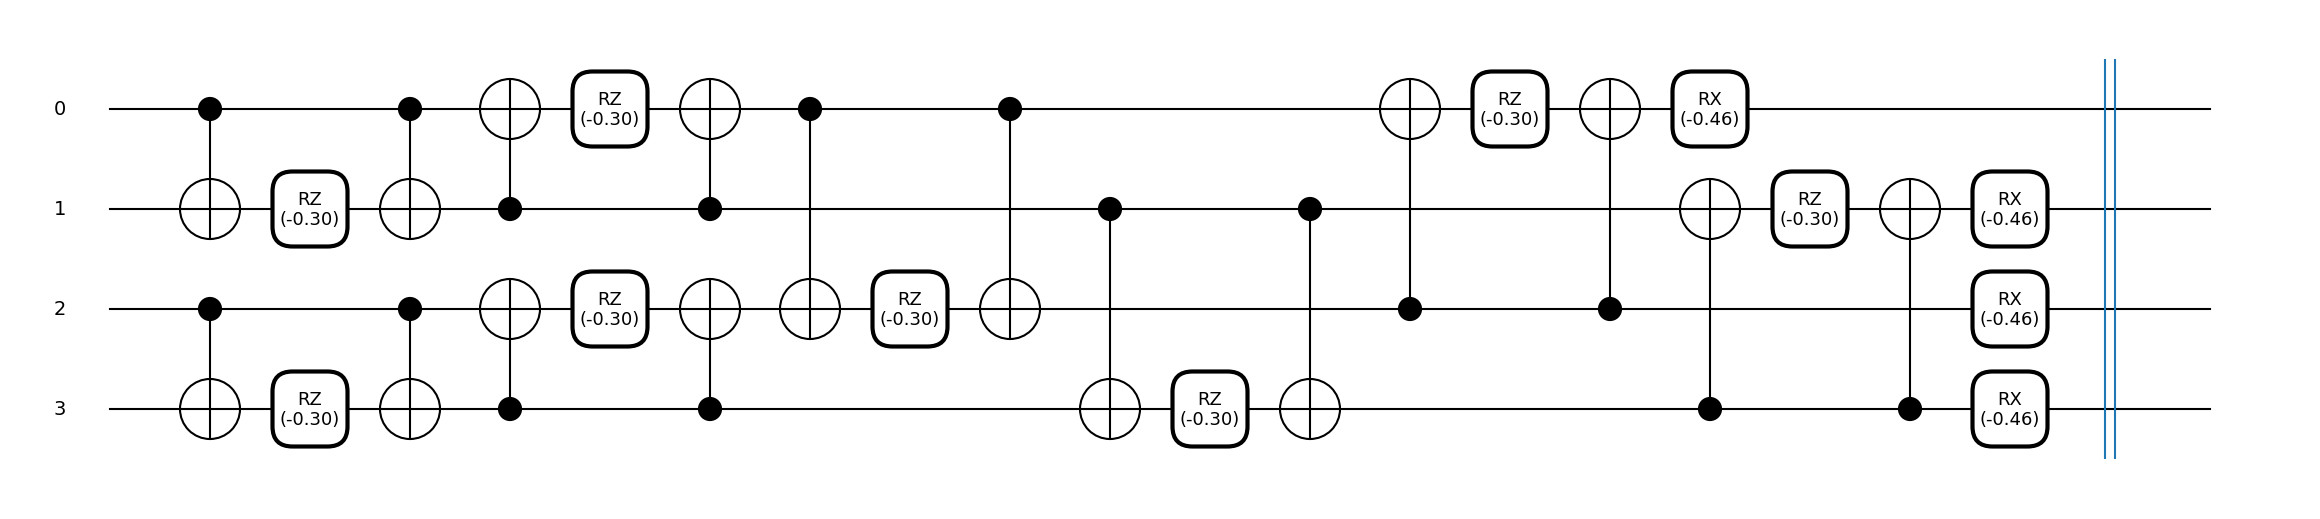

In [7]:
qml.draw_mpl(SGS_circ, decimals=2)(hX, JX=0, JY=0, JZ=1,tau_steps=1)

Here we check that the SGS state is approximately an equal superposition of the ground and theexcited state

In [8]:
def fidelity(a,b):
    return abs(np.vdot(np.array(a, dtype = 'complex128'),np.array(b, dtype = 'complex128')))**2               
def overlap(a,b):
    return np.vdot(np.array(a, dtype = 'complex128'),np.array(b, dtype = 'complex128'))#abs()**2

In [9]:
statevec = SGS_state(hX, JX, JY, JZ,tau_steps=tau_steps, delta_tau=delta_tau)


print('{:.3f},{:.3f}'.format(fidelity(grounds[0], statevec), fidelity(excs[0], statevec)))

0.427,0.457


/home/francesco/anaconda3/envs/qhack/lib/python3.12/site-packages/pennylane/_qubit_device.py:653: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


To have better fitting we will employ Chebyshev timesteps in the time evolution process

In [10]:
def chebyshev_time(t_steps, delta_t):
    '''Using Chebyshev nodes as time to have better fit'''

    n_nodes = []
    
    for t in range(t_steps):
        n_nodes.append(t_steps*delta_t*(0.5*np.cos(np.pi*(t_steps-1-t)/(t_steps-1))+0.5))

    return n_nodes

In [11]:
#### Equally spaced time steps
### alternative


# def time_evolution(hX, JX=0, JY=0, JZ=0,t_steps=10, delta_t = 0.3):
    
#     for t in range(t_steps):
#         trotter_step(1,hX,JX,JY,JZ, delta_t)



# device = qml.device("lightning.qubit", wires=n_qubits, shots=8192)

# @qml.qnode(device)
# def evol_SGS_expval(hX, JX=0, JY=0, JZ=0,tau_steps=10,t_steps=10, delta_tau = 0.3,delta_t = 0.3, O=qml.PauliZ(0)):
    
#     SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau)
    
#     time_evolution(hX, JX, JY, JZ,t_steps, delta_t)

#     return qml.expval(O)

# @qml.qnode(device,)
# def evol_SGS_state(hX, JX=0, JY=0, JZ=0,tau_steps=10,t_steps=10, delta_tau = 0.3,delta_t = 0.3,):
    
#     SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau)
    
#     time_evolution(hX, JX, JY, JZ,t_steps, delta_t)

#     return qml.state()



In [12]:
#### CHEBYSHEV TIMESTEPS
def time_evolution(hX, JX=0, JY=0, JZ=0,t_steps=10, step=0, delta_t = 0.3):
    times = chebyshev_time(t_steps, delta_t)

    for i,t in enumerate(times[:step]):#range(t_steps):
        if i==0:
            dt=t
        else:
            dt = t - times[i-1]
        trotter_step(1,hX,JX,JY,JZ, dt)



device = qml.device("lightning.qubit", wires=n_qubits, shots=8192,)

@qml.qnode(device)
def evol_SGS_expval(hX, JX=0, JY=0, JZ=0,tau_steps=10,t_steps=10, step=0, delta_tau = 0.3,delta_t = 0.3, O=qml.PauliZ(0)):
    '''Circuit returning the expectation value of time evoluted Z_0 on the SGS state obtained via Adiabatic Thermalization
    '''
    SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau)
    
    time_evolution(hX, JX, JY, JZ,t_steps,step, delta_t)

    return qml.counts(op = O, )#qml.expval(O)

@qml.qnode(device,interface='jax')
def evol_SGS_state(hX, JX=0, JY=0, JZ=0,tau_steps=10,t_steps=10, step=0, delta_tau = 0.3,delta_t = 0.3,):
    '''Circuit returning the SGS state obtained via Adiabatic Thermalization and then time evoluted
    '''
    SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau, )
    
    time_evolution(hX, JX, JY, JZ,t_steps, step, delta_t)

    return qml.state()



Again we check that the SGS state is approximately an equal superposition of the ground and the excited state during the time evolution

In [13]:
for t in range(t_steps):
    statevec = evol_SGS_state(hX, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,step=t,delta_t=delta_t,delta_tau=delta_tau)
    print(t, '{:.3f},{:.3f}'.format(fidelity(grounds[0], statevec), fidelity(excs[0], statevec)))

0 0.427,0.457
1 0.427,0.457
2 0.428,0.457
3 0.436,0.467
4 0.461,0.494
5 0.464,0.471
6 0.459,0.369
7 0.372,0.453
8 0.281,0.424
9 0.340,0.332
10 0.457,0.458
11 0.257,0.271
12 0.223,0.459
13 0.411,0.252
14 0.326,0.462
15 0.216,0.262
16 0.357,0.477
17 0.409,0.299
18 0.367,0.475
19 0.320,0.398
20 0.390,0.400
21 0.457,0.498
22 0.496,0.466
23 0.475,0.440
24 0.464,0.441


And now we are ready to compute the expectation value at different time steps:

In [14]:
vals = []
errors = []
for t in range(t_steps):
    expval=0
    counts = evol_SGS_expval(hX, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,step=t,delta_t=delta_t,delta_tau=delta_tau)
    shots = counts[1]+counts[-1]
    p_0 = counts[1]/shots
    p_1 = counts[-1]/shots
    expval = (p_1*(-1)+ p_0)
    err = np.sqrt(4*p_0*p_1/(shots-1))# /
    errors.append(err)
    vals.append(expval)
    if t%5==0:
        print(t, f'{expval:.3f}, {err:.3f}')

0 0.139, 0.011


5 -0.387, 0.010
10 -0.301, 0.011
15 0.549, 0.009
20 -0.478, 0.010


In the end we fit the points with a `cosine` function. The spectral gap will be given by
$$\Delta E = \frac{2\pi}{T}$$
where $T$ is the period of the oscillating function.

Numerical: 1.24181
Estimated: 1.07213+/-0.018712
Reltive error: 0.13663586161719476


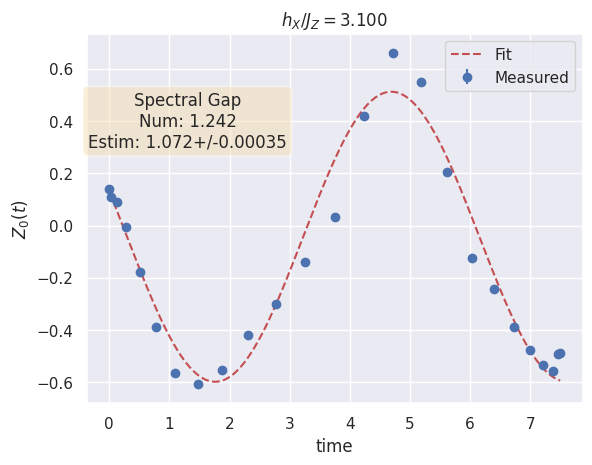

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.optimize import curve_fit
#FITTING PROCESS

def prefitting_function (x,a,b,c,d):
    f = a + b*np.cos(c*x + d)
    return f

x_axis =np.array(chebyshev_time(t_steps, delta_t))##np.linspace(0, t_steps*delta_t, t_steps)# 

omega = 0.2#2*np.pi/14.5

p, pcov = curve_fit(prefitting_function, x_axis , vals, sigma= np.array(errors),
                    p0 = [ 0., .4, omega, 0],)
                    

plot_x_axis = np.linspace(0, t_steps*delta_t, 1000)
plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p[0], p[1], p[2], p[3]),linestyle='dashed', label='Fit', color='r')

plt.title(rf'$h_X/J_Z={hX:.3f}$')
plt.xlabel("time")
plt.ylabel(r"$Z_0(t)$")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



print(f'Numerical: {spectral_gap:.5f}')
estim_gap = np.abs(p[2])
print(f'Estimated: {estim_gap:.5f}+/-{np.sqrt(pcov[2][2]):.5g}')
relativ_err = np.abs(spectral_gap-p[2])/spectral_gap
print(f'Reltive error: {relativ_err}')
plt.text(1.3,0.3, f'Spectral Gap\nNum: {spectral_gap:.3f}\nEstim: {estim_gap:.3f}+/-{pcov[2][2]:.3g}', 
         fontsize='medium', bbox=props, horizontalalignment='center')#, zorder=z)
# plt.grid()
plt.legend()
plt.show()

## Ising model scanning

In this section we scan all the Ising model regimes allowed by employ 40 Trotter steps and show that we can estimate the spectral gap.

In [16]:
n_qubits = 4

tau_steps = 15 # thermaliztion steps
t_steps = 25 # time evolution steps

JZ = 1
JX = 0
JY = 0

In [32]:
## DISCLAIMER: this automatic procedure may fail in performing the fitting
##              one should redo a separate fit in order to obtain a good estimate of the spectral gap

numerical_gaps = []
esitmated_gaps = []
fit_errors = []


hX_s = np.linspace(2.5,7,15)

for k,hX in enumerate(hX_s):
    
    print(f'\n---hX={hX:.3f}---')
    # different regimes needs different time steps
    # the period is inverse proportial to the spectral gap
    # thermalization step adjusting
    if hX >= 4.:
        delta_tau = 0.5
    elif 2.6 < hX < 4.:
        delta_tau = 0.4
    else: 
        delta_tau = 0.3

    ## time ev step adjusting
    ## fitting parameter adjusting
    if 2.5<=hX<3.:
        delta_t = 0.3
        omega = 1.
    elif 3.<=hX<3.5:
        delta_t = 0.2
        omega = 1
    elif 3.5<=hX<4.4:
        delta_t = 0.2
        omega = 2
    elif 4.4<=hX<5:
        delta_t = 0.2
        omega = 2.5
    elif 5<=hX<5.5:
        delta_t = 0.2
        omega = 3
    elif 5.5<=hX<6.5:
        delta_t = 0.2
        omega = 4
    elif hX>6.5:
        delta_t = 0.2
        omega = 5.3

    #numerical gap
    grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hX)
    spectral_gap = (eigenvals[1]-eigenvals[0]).real
    numerical_gaps.append(spectral_gap)

    # our estimate of the gap
    vals = []
    errors = []
    for t in range(t_steps):
        expval=0
        counts = evol_SGS_expval(hX, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,step=t,delta_t=delta_t,delta_tau=delta_tau)
        shots = counts[1]+counts[-1]
        p_0 = counts[1]/shots
        p_1 = counts[-1]/shots
        expval = (p_1*(-1)+ p_0)
        err = np.sqrt(4*p_0*p_1/(shots-1))# /
        errors.append(err)
        vals.append(expval)

    ## fitting 
    x_axis = np.array(chebyshev_time(t_steps, delta_t))
    p0 = [ 0., 0.4, omega , 0] # initial fitting parameters
    # plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
    p, pcov = curve_fit(prefitting_function, x_axis , vals, p0 = p0,sigma=errors)
   
        
    estim_gap = np.abs(p[2])
    esitmated_gaps.append(estim_gap)
    print(f'Numerical: {spectral_gap:.5f}')
    fit_err = np.sqrt(pcov[2][2])
    fit_errors.append(fit_err)
    print(f'Estimated: {estim_gap:.5f}+/-{fit_err:.5g}')
    relativ_err = np.abs(spectral_gap-estim_gap)/spectral_gap
    # if relativ_err>0.1:
    #     break
    print(f'Reltive error: {relativ_err}')
    


---hX=2.500---
Numerical: 0.74325
Estimated: 0.37764+/-0.18081
Reltive error: 0.49190353183787683

---hX=2.821---
Numerical: 1.00216
Estimated: 0.91486+/-0.019951
Reltive error: 0.0871192234143137

---hX=3.143---
Numerical: 1.27964
Estimated: 1.27999+/-0.031999
Reltive error: 0.0002749757930892741

---hX=3.464---
Numerical: 1.56973
Estimated: 1.48738+/-0.045528
Reltive error: 0.05246196992705797

---hX=3.786---
Numerical: 1.86842
Estimated: 1.84716+/-0.056358
Reltive error: 0.011381854101534503

---hX=4.107---
Numerical: 2.17306
Estimated: 2.11220+/-0.075288
Reltive error: 0.02801012276292718

---hX=4.429---
Numerical: 2.48187
Estimated: 2.45670+/-0.059877
Reltive error: 0.010144835400412824

---hX=4.750---
Numerical: 2.79366
Estimated: 3.00265+/-0.10977
Reltive error: 0.07480690933337349

---hX=5.071---
Numerical: 3.10761
Estimated: 3.09666+/-0.20209
Reltive error: 0.003525130454247043

---hX=5.393---
Numerical: 3.42316
Estimated: 3.36307+/-0.13734
Reltive error: 0.01755467468278465


In [36]:
full_range_gap = []
for hX in  np.linspace(0,8,100):
    grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hX)
    spectral_gap = (eigenvals[1]-eigenvals[0]).real
    full_range_gap.append(spectral_gap)

/tmp/ipykernel_243262/945356955.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(hX_s, esitmated_gaps,yerr=fit_errors, label='Noiseless',


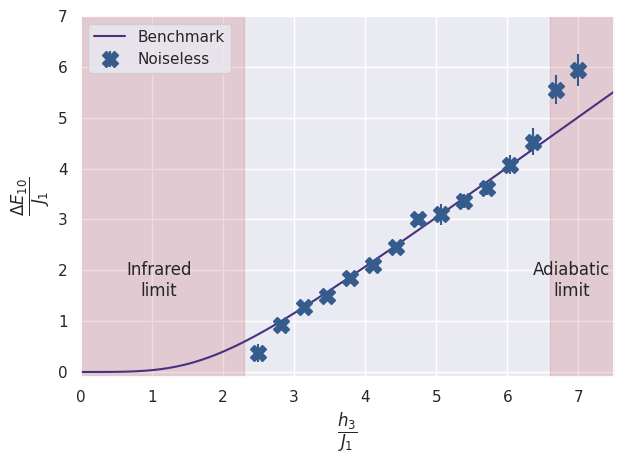

In [42]:
fig, ax = plt.subplots()
cmap = sns.color_palette("viridis")
plt.plot(np.linspace(0,8,100), full_range_gap, label='Benchmark', c=cmap[0])
plt.errorbar(hX_s, esitmated_gaps,yerr=fit_errors, label='Noiseless', 
             fmt='o', marker='X', markersize=12,c=cmap[1])

plt.xlabel(r'$\dfrac{h_3}{J_1}$')
plt.ylabel(r'$\dfrac{\Delta E_{10}}{J_1}$')
# plt.xscale('log')
# plt.yscale('log')
ax.fill_betweenx([-1.,7.1], [0,], [2.3], alpha=0.2, color='r')
ax.fill_betweenx([-1.,7.1], [6.6], [7.5], alpha=0.2, color='r')
plt.text(1.1,1.5, f'Infrared\nlimit', fontsize='medium',  horizontalalignment='center')
plt.text(6.9,1.5, f'Adiabatic\nlimit', fontsize='medium',  horizontalalignment='center')
ax.set_ylim([-0.1, 7])
ax.set_xlim([0,7.5])
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f'./images/Ising_2D_spectralgap_running_{n_qubits}.pdf')
plt.show()